In [1]:
import os
import re
import dotenv
import numpy as np
from numpy import inf
import pandas as pd
from pprint import pprint

# library for save and load scikit-learn models
import pickle

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import dtreeviz

import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [22]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [14]:
X = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/X_decision_trees.csv', encoding='utf-8')
X = X.iloc[:, :20]
y = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_both.csv', encoding='utf-8')

In [15]:
X = X.set_index('ID')
y = y.set_index('ID')

In [16]:
# X = df.loc[:, ["post_id", "log_init_imps", "log_init_engs", "Dominant_Topic", "Keywords"]]
# X = X.set_index('post_id')
# X = pd.concat([X.drop(columns=['Keywords']), X['Keywords'].str.get_dummies(sep=",")], axis=1)
# X = pd.concat([X.drop(columns=['Dominant_Topic']), X['Dominant_Topic'].astype(str).str.get_dummies()], axis=1)
# #X = pd.concat([df_ready.drop(columns=['Keywords']), df_ready['Keywords'].str.get_dummies(sep=",")], axis=1)
# #X = pd.concat([df_ready.drop(columns=['Dominant_Topic']), df_ready['Dominant_Topic'].str.get_dummies()], axis=1)
# y = df.loc[:, ["post_id", "log_all_engrate"]]
# y = y.set_index('post_id')
# y = y.squeeze()
print(X.head())
print(y.head())

                                  has_any_image  hashtags_count  \
ID                                                                
urn:li:share:7015210047886524416              1               0   
urn:li:share:7015240414274158592              1               0   
urn:li:share:7015593540680351744              1               0   
urn:li:share:7015632542909276162              1               0   
urn:li:share:7015768702277066752              1               2   

                                  has_any_hashtag  week_posted  \
ID                                                               
urn:li:share:7015210047886524416                0           52   
urn:li:share:7015240414274158592                0           52   
urn:li:share:7015593540680351744                0            1   
urn:li:share:7015632542909276162                0            1   
urn:li:share:7015768702277066752                1            1   

                                  weekday_posted  day_posted  hour_

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['fanpage_id'])

In [18]:
X_train = X_train.drop(columns=['fanpage_id'])
X_test = X_test.drop(columns=['fanpage_id'])
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [19]:
# fit the regressor
reg = tree.DecisionTreeRegressor(random_state=42)

In [20]:
warnings.filterwarnings("ignore")
scorer = make_scorer(r2_score)
param_grid = {
    'max_depth': [4, 6, 8, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 4, 6, 8, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6]  # Minimum number of samples required to be a leaf node
}

grid_search = GridSearchCV(reg, param_grid, cv=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Find the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [21]:
print(best_params)

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [25]:
y_test

ID
urn:li:share:7030506572665487360      0.016393
urn:li:ugcPost:7043874758152626176    0.108422
urn:li:ugcPost:7061990328483921920    0.657143
urn:li:share:7054023098810916864      0.030337
urn:li:share:7019230110809509888      0.078782
                                        ...   
urn:li:ugcPost:7042782116618629120    0.358382
urn:li:share:7042475929545170945      0.022959
urn:li:share:7084449407479209984      0.063492
urn:li:share:7051439749831479297      0.032051
urn:li:share:7056205798233772033      0.031746
Name: eng_rate, Length: 324, dtype: float64

In [22]:
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Train R-squared: {train_score:.2f}")
print(f"Test R-squared: {test_score:.2f}")

Train R-squared: 0.07
Test R-squared: -0.00


In [23]:
# get train/test predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [26]:
# plot the tree
viz_model = dtreeviz.model(
    best_model,
    X_train=X_train,
    y_train=y_train,
    target_name='eng_rate',
    feature_names=X_train.columns
)
v = viz_model.view()     # render as SVG into internal object 
v.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

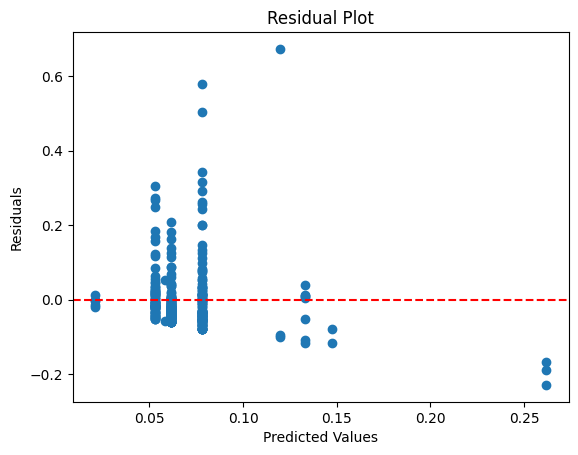

In [27]:
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

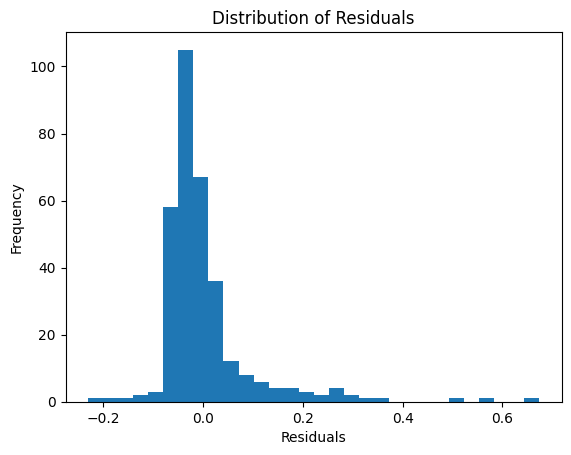

In [28]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

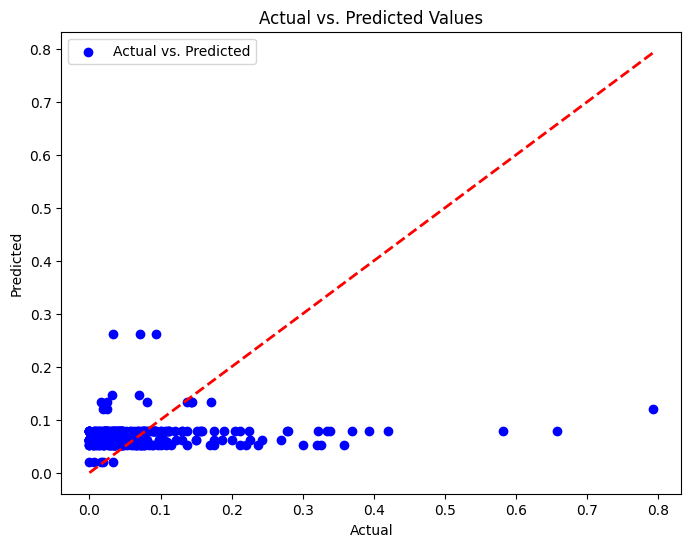

In [29]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [24]:
# Save the model
with open(os.path.join(os.getenv('TRAINED_MODELS_PATH'), 'decision_tree_model.pkl'), 'wb') as f:
    pickle.dump(best_model, f)